In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,Bidirectional,GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
import datetime
import io
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import sys
import os
# Obtener la ruta del directorio actual
os.chdir('/home/rgadea/experimentos_software_2024')
current_dir = os.getcwd()
print(current_dir)

# Construir la ruta relativa al directorio que quieres agregar
relative_dir = os.path.join(current_dir, 'mis_pkgs/')

# Agregar la ruta relativa al sys.path
sys.path.insert(0, relative_dir)

from MIOPATIA_db import DB_management as db 


2024-05-10 11:18:16.392181: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 11:18:16.392242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 11:18:16.393813: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-10 11:18:16.404178: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 11:18:17.211115: W tensorflow/comp

/home/rgadea/experimentos_software_2024


Voy a quedarme con los 50 atunes P1 para obtener conjunto de training y validacion

In [2]:
!pwd


/home/rgadea/experimentos_software_2024


In [37]:
filename = "lomosP1_20240430_ESTADOPH_ampliado_the_best6.hdf"
with pd.HDFStore(filename,complib="zlib",complevel=4) as hdf_db:
    pre_p_e1  = hdf_db.get('data/pollos_estado')
    pre_p_e1 = pre_p_e1.loc[pre_p_e1['Pollo'] != 0]
    # p_e =pre_p_e1.drop_duplicates(subset = ['Pollo', 'Medida'],  keep = 'last').reset_index(drop = True)
    t    = hdf_db.get('data/tabla')
    X_train=np.zeros((pre_p_e1.shape[0],220,8))
    y_train=np.zeros((pre_p_e1.shape[0],1))
    x=0
    for index, row in pre_p_e1.iterrows():   # El primer registro no se toma en cuenta porque es basura
        Primero = int(row['Primero'])
        Ultimo  = int(row['Ultimo'])
        estado  = float(row['Estado'])
        #print(Primero)
        #print(Ultimo)
        #print(estado)
        #if estado == 0 or estado== 1:
        #    target = 1
        #else:
        #    target = 0
        target=estado
        pepito=np.array(t.iloc[Primero:Ultimo+1])
        # #print(pepito.shape)
        X_train[x]=pepito[:,3:11]
        #print(X_train[x][0:4,:])       
        y_train[x]=target
        # y_train_to_categorical = to_categorical(y_train)
        x=x+1

print(y_train)
# print(X_train.shape)
# print(y_train_to_categorical.shape)
# #print(X_train[0:4,:,:])
# #print(X_train[1][0:4][:])
# print(y_train[1:20])
# print(y_train_to_categorical[1:20])
# # #Aqui filtrariamos si hay filas que no nos interesan. En este caso dejo pasar todos los casos
# print(p_e)
# # X_train_filtrado = X_train[2:][:,:]
# # y_train_filtrado = y_train[2:]
X_train_filtrado = X_train
y_train_filtrado = y_train
#y_train_filtrado = y_train_to_categorical

# print(X_train_filtrado.shape)
# print(y_train_filtrado.shape)
# print(X_train_filtrado[0][:,:])
# # # Vamos a normalizar o escalar los datos
scaler_in = MinMaxScaler(feature_range=(0, 1))
data_2d_in = X_train_filtrado.reshape(-1, X_train_filtrado.shape[-1])
normalized_data_2d_in = scaler_in.fit_transform(data_2d_in)

scaler_out = MinMaxScaler(feature_range=(-1, 1))
data_2d_out = y_train_filtrado.reshape(-1, y_train_filtrado.shape[-1])
normalized_data_2d_out = scaler_out.fit_transform(data_2d_out)


X_train_Normalizado=normalized_data_2d_in.reshape(X_train_filtrado.shape)
y_train_Normalizado=normalized_data_2d_out.reshape(y_train_filtrado.shape)
#y_train_Normalizado=y_train_filtrado # los valores ya estaban normalizados
print(X_train_Normalizado[0])

[[6.09000015]
 [6.09000015]
 [6.09000015]
 ...
 [6.09000015]
 [6.09000015]
 [6.09000015]]
[[5.59059849e-04 6.02334232e-01 2.09243895e-01 ... 3.97666103e-01
  5.59148408e-04 8.98444367e-01]
 [5.32692283e-04 6.01851048e-01 2.10280898e-01 ... 3.98149286e-01
  5.32776684e-04 8.98444937e-01]
 [5.23422176e-04 6.02312810e-01 2.08059305e-01 ... 3.97687525e-01
  5.23505162e-04 8.98445730e-01]
 ...
 [6.90117158e-07 4.10655386e-01 1.65373568e-01 ... 5.89344843e-01
  6.90201187e-07 8.98463166e-01]
 [3.49024769e-07 4.14711733e-01 1.65342858e-01 ... 5.85288497e-01
  3.49145000e-07 8.98463350e-01]
 [0.00000000e+00 4.19288217e-01 1.65312668e-01 ... 5.80712016e-01
  1.56981087e-10 8.98463540e-01]]


In [38]:
filename = "lomosP2_20240430_ESTADOph.hdf"
with pd.HDFStore(filename,complib="zlib",complevel=4) as hdf_db:
    pre_p_e1  = hdf_db.get('data/pollos_estado')
    pre_p_e1 = pre_p_e1.loc[pre_p_e1['Pollo'] != 0]
    pre_p_e1 =pre_p_e1.drop_duplicates(subset = ['Pollo', 'Medida'],  keep = 'last').reset_index(drop = True)
    t    = hdf_db.get('data/tabla')
    X_test=np.zeros((pre_p_e1.shape[0],220,8))
    y_test=np.zeros((pre_p_e1.shape[0],1))
    x=0
    for index, row in pre_p_e1.iterrows():   # El primer registro no se toma en cuenta porque es basura
        Primero = int(row['Primero'])
        Ultimo  = int(row['Ultimo'])
        estado  = float(row['Estado'])
        #print(Primero)
        #print(Ultimo)
        #print(estado)
        #if estado == 0 or estado== 1:
        #    target = 1
        #else:
        #    target = 0
        target=estado
        pepito=np.array(t.iloc[Primero:Ultimo+1])
        # #print(pepito.shape)
        X_test[x]=pepito[:,3:11]
        #print(X_train[x][0:4,:])       
        y_test[x]=target
        # y_test_to_categorical = to_categorical(y_test)
        x=x+1

print(y_test)
# print(X_train.shape)
# print(y_train_to_categorical.shape)
# #print(X_train[0:4,:,:])
# #print(X_train[1][0:4][:])
# print(y_train[1:20])
# print(y_train_to_categorical[1:20])
# # #Aqui filtrariamos si hay filas que no nos interesan. En este caso dejo pasar todos los casos
# print(p_e)
# # X_train_filtrado = X_train[2:][:,:]
# # y_train_filtrado = y_train[2:]
X_test_filtrado = X_test
#y_train_filtrado = y_train
#y_test_filtrado = y_test_to_categorical
y_test_filtrado = y_test

print(X_test_filtrado.shape)
print(y_test_filtrado.shape)
# print(X_train_filtrado[0][:,:])
# # # Vamos a normalizar o escalar los datos
# concatenamos train y test
#X_total=np.concatenate((X_train_filtrado,X_test_filtrado),axis=0)

#data_2d_test = X_total.reshape(-1, X_total.shape[-1])
data_2d_test = X_test_filtrado.reshape(-1, X_test_filtrado.shape[-1])
normalized_data_2d_test = scaler_in.transform(data_2d_test)


X_test_def=normalized_data_2d_test.reshape(X_test_filtrado.shape) 
# la alternativa es normalizar con el total
# X_test_def=normalized_data_2d_test.reshape(X_test_filtrado.shape) 


data_2d_out_test = y_test_filtrado.reshape(-1, y_test_filtrado.shape[-1])
normalized_data_2d_out_test = scaler_out.transform(data_2d_out_test)

y_test_def=normalized_data_2d_out_test.reshape(y_test_filtrado.shape) 
# y_test_def=y_test_filtrado # los valores ya estaban normalizados
#print(y_test_filtrado)

[[5.90999985]
 [5.90999985]
 [5.90999985]
 [5.90999985]
 [6.03000021]
 [6.03000021]
 [6.03000021]
 [6.03000021]
 [5.86000013]
 [5.86000013]
 [5.86000013]
 [5.86000013]
 [5.8499999 ]
 [5.8499999 ]
 [5.8499999 ]
 [5.8499999 ]
 [5.82999992]
 [5.82999992]
 [5.82999992]
 [5.82999992]
 [6.09000015]
 [6.09000015]
 [6.09000015]
 [6.09000015]
 [6.19000006]
 [6.19000006]
 [6.19000006]
 [6.19000006]
 [6.07999992]
 [6.07999992]
 [6.07999992]
 [6.07999992]
 [5.84000015]
 [5.84000015]
 [5.84000015]
 [5.84000015]
 [6.07000017]
 [6.07000017]
 [6.07000017]
 [6.07000017]
 [6.15999985]
 [6.15999985]
 [6.15999985]
 [6.15999985]
 [5.94999981]
 [5.94999981]
 [5.94999981]
 [5.94999981]
 [5.86999989]
 [5.86999989]
 [5.86999989]
 [5.86999989]
 [5.96000004]
 [5.96000004]
 [5.96000004]
 [5.96000004]
 [5.80999994]
 [5.80999994]
 [5.80999994]
 [5.80999994]
 [6.13999987]
 [6.13999987]
 [6.13999987]
 [6.13999987]
 [5.76000023]
 [5.76000023]
 [5.76000023]
 [5.76000023]
 [5.9000001 ]
 [5.9000001 ]
 [5.9000001 ]
 [5.90

Vamos a hacer los conjuntos de entrenamiento validacion y test

In [5]:
# Divide el dataset en entrenamiento y temporal (test+validación)
# X_temp, X_test_def, y_temp, y_test_def = train_test_split(X_train_Normalizado, y_train_Normalizado, test_size=0.2, stratify=y_train_Normalizado, random_state=42)

# Divide el dataset temporal en validación y test
X_train_def, X_val_def, y_train_def, y_val_def = train_test_split(X_train_Normalizado, y_train_Normalizado, test_size=0.25, stratify=y_train_Normalizado, random_state=42)

# Ahora, X_train, X_val y X_test contienen los datos de entrada para los conjuntos de entrenamiento, validación y prueba, respectivamente.
# y_train, y_val y y_test contienen las clases correspondientes.

In [39]:
print(X_train_def.shape)
print(X_val_def.shape)
print(X_test_def.shape)
print(y_train_def.shape)
print(y_val_def.shape)
print(y_test_def.shape)

(4950, 220, 8)
(1650, 220, 8)
(200, 220, 8)
(4950, 1)
(1650, 1)
(200, 1)


In [7]:
%load_ext tensorboard

#%tensorboard --logdir logs
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [8]:
def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

In [9]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    threshold = 0.5
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "red" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [10]:
algoritmo='RMSprop'
supermax=8*4
lossfunction='mse'
factor_aprendizaje=0.001
dimension_LSTM=50
dimension_dense=50
model = Sequential()
model.add(GRU(dimension_LSTM, return_sequences=False,input_shape=(220, 8)))
#model.add(Bidirectional(LSTM(50, return_sequences=True)))
#model.add(Bidirectional(LSTM(50, return_sequences=True)))
#model.add(Bidirectional(LSTM(50, return_sequences=False)))
model.add(Dense(dimension_dense, activation='tanh'))
model.add(Dense(1, activation='tanh'))
model.compile(loss=lossfunction, optimizer=algoritmo, metrics=['mean_squared_error'])
model.optimizer.lr=(factor_aprendizaje)
print(model.summary())

experimento="LOMOS_P1 yP2_GRU2_best7_{}_dense_regression_{}_loss_{}_lr_{}_algoritmo_{}".format(dimension_LSTM,dimension_dense,lossfunction,factor_aprendizaje,algoritmo)
logdir="./logs/defs/{}_{}".format(experimento,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')


2024-05-10 11:18:21.835244: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-05-10 11:18:21.835494: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: nodofpga-2024.novalocal
2024-05-10 11:18:21.835583: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: nodofpga-2024.novalocal
2024-05-10 11:18:21.836058: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.161.7
2024-05-10 11:18:21.836288: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.161.7
2024-05-10 11:18:21.836330: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.161.7


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                9000      
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11601 (45.32 KB)
Trainable params: 11601 (45.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [11]:
class_names=["A","B+","B","B-", "C"]

In [12]:
def log_confusion_matrix(epoch, logs):
    
    # Use the model to predict the values from the test_images.
    y_pred = model.predict(X_val_def)
    #y_pred1=y_pred[:,-1]
    y_pred2=y_pred.argmax(axis=1)
    #y_pred2=np.where(y_pred>0,1,0)
    #y_pred2=y_pred2[:,-1]
    classes = [0, 1, 2, 3, 4]
    y_val_def2=np.argmax(y_val_def,axis=1)  
    #y_test_def2=np.where(y_test_def>0,1,0)
    cm=confusion_matrix(y_val_def2, y_pred2,labels=classes)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    figura = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figura)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [13]:
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
print(y_train_Normalizado.shape)
print(y_val_def.shape)

(6600, 1)
(1650, 1)


In [14]:
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None, restore_best_weights=True)
model.fit(X_train_Normalizado, y_train_Normalizado, epochs=400, batch_size=20, callbacks=[tensorboard_callback, early_stop], validation_data=(X_val_def, y_val_def))
# Final evaluation of the model 
scores = model.evaluate(X_test_def, y_test_def, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/400
330/330 [==============================] - 24s 68ms/step - loss: 0.2030 - mean_squared_error: 0.2030 - val_loss: 0.2034 - val_mean_squared_error: 0.2034
Epoch 2/400
330/330 [==============================] - 21s 65ms/step - loss: 0.2003 - mean_squared_error: 0.2003 - val_loss: 0.1991 - val_mean_squared_error: 0.1991
Epoch 3/400
330/330 [==============================] - 21s 65ms/step - loss: 0.1991 - mean_squared_error: 0.1991 - val_loss: 0.1962 - val_mean_squared_error: 0.1962
Epoch 4/400
330/330 [==============================] - 21s 64ms/step - loss: 0.1987 - mean_squared_error: 0.1987 - val_loss: 0.1987 - val_mean_squared_error: 0.1987
Epoch 5/400
330/330 [==============================] - 21s 63ms/step - loss: 0.1977 - mean_squared_error: 0.1977 - val_loss: 0.2048 - val_mean_squared_error: 0.2048
Epoch 6/400
330/330 [==============================] - 21s 64ms/step - loss: 0.1972 - mean_squared_error: 0.1972 - val_loss: 0.1938 - val_mean_squared_error: 0.1938
Epoch 7/40

KeyboardInterrupt: 

In [ ]:
model=tf.keras.models.load_model("modelos/modelo_perfecto_LOMOS_P1 yP2_GRU1_50_dense_regression_50_loss_mse_lr_0.001_algoritmo_RMSprop_20240507-161050")

In [40]:
from scipy import stats
y_pred = model.predict(X_test_def)
y_pred2 = scaler_out.inverse_transform(y_pred) #valor denormalizado

#y_pred1=y_pred[:,-1]
# y_pred2=np.argmax(y_pred,axis=1)
n = len(y_pred2)
reshaped = y_pred2[:n//4*4].reshape(-1, 4)
mean_values = reshaped.mean(axis=1)

# mean_values = np.round(mean_values)
# mean_values = np.clip(mean_values, 0, 4)
# mean_values = mean_values.astype(int)
#print(y_pred)
print(y_pred2)
#print(mean_values)

# mode_values = stats.mode(reshaped, axis=1)[0]
# print(mode_values)

# Convierte los arrays a DataFrames
mean_df = pd.DataFrame(mean_values, columns=['mean'])
#mode_df = pd.DataFrame(mode_values, columns=['mode'])

# Guarda los DataFrames en archivos Excel
mean_df.to_excel("regression_P2_mean.xlsx", index=False)
#mode_df.to_excel("clasificacion_P2_mode.xlsx", index=False)

# np.savetxt("clasificacion_P2_mean.csv", mean_values, delimiter=",")
# np.savetxt("clasificacion_P2_mode.csv", mean_values, delimiter=",")

7/7 [==============================] - 0s 21ms/step
[[5.9470043]
 [5.979098 ]
 [6.045999 ]
 [6.1952868]
 [6.2746425]
 [6.249964 ]
 [6.003847 ]
 [5.910858 ]
 [5.868349 ]
 [5.9817176]
 [6.006286 ]
 [5.811013 ]
 [6.0245667]
 [5.9769907]
 [5.9903035]
 [6.032954 ]
 [5.9666204]
 [5.9720173]
 [5.950905 ]
 [6.021338 ]
 [5.9507065]
 [5.95989  ]
 [6.070228 ]
 [5.8886347]
 [6.0429997]
 [6.10706  ]
 [6.034039 ]
 [6.056192 ]
 [6.0992603]
 [6.002922 ]
 [6.1822367]
 [6.073327 ]
 [5.9125876]
 [5.855528 ]
 [6.0443482]
 [5.922881 ]
 [6.082511 ]
 [5.9726553]
 [6.172615 ]
 [5.982879 ]
 [6.161602 ]
 [5.8216   ]
 [6.1947584]
 [6.1571946]
 [5.7742786]
 [6.0076632]
 [5.972488 ]
 [6.152958 ]
 [6.126132 ]
 [6.1036706]
 [6.0846505]
 [5.7408686]
 [5.97391  ]
 [5.891122 ]
 [6.016961 ]
 [5.9920454]
 [6.0357594]
 [6.0981646]
 [5.98847  ]
 [5.7424803]
 [6.0717278]
 [6.0358424]
 [6.1528783]
 [5.9662094]
 [6.0737524]
 [5.951121 ]
 [5.978811 ]
 [6.1552153]
 [6.0785666]
 [5.806113 ]
 [6.1354604]
 [5.9982915]
 [6.094517 ]

In [ ]:
# y_pred = model.predict(X_test_def)
# #y_pred1=y_pred[:,-1]
# y_pred2=np.argmax(y_pred,axis=1)
# #y_pred2=np.where(y_pred>0,1,0)
# #y_pred2=y_pred2[:,-1]
# y_test_def2=np.argmax(y_test_def,axis=1)
# #y_test_def2=np.where(y_test_def>0,1,0)
# print(y_pred.shape)
# print(y_pred2.shape)
# print(y_test_def2.shape)
# #print(y_test_def[25])

In [ ]:
# #docs_infra: no_execute
# classes = [0, 1, 2, 3, 4]
# cm=confusion_matrix(y_test_def2, y_pred2,labels=classes)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()
# plt.show()

In [ ]:
# model.save('modelos/modelote1203_200')  # creates a HDF5 file 'my_model.h5'

In [16]:
model.save('modelos/modelo_perfecto_{}_{}'.format(experimento,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))) 

INFO:tensorflow:Assets written to: modelos/modelo_perfecto_LOMOS_P1 yP2_GRU2_best7_50_dense_regression_50_loss_mse_lr_0.001_algoritmo_RMSprop_20240510-122922/assets


INFO:tensorflow:Assets written to: modelos/modelo_perfecto_LOMOS_P1 yP2_GRU2_best7_50_dense_regression_50_loss_mse_lr_0.001_algoritmo_RMSprop_20240510-122922/assets


52/52 [==============================] - 1s 22ms/step
(1650, 1)


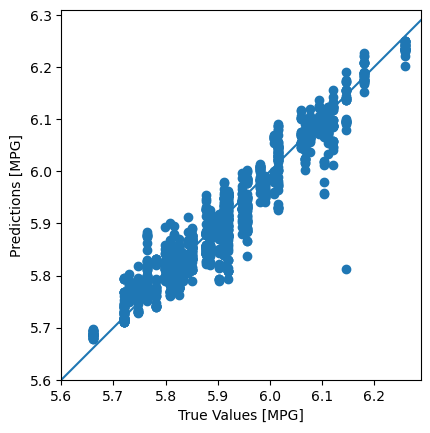

In [19]:
val_predictions = model.predict(X_val_def)
print(val_predictions.shape)
val_predictions_denor = scaler_out.inverse_transform(val_predictions) #valor denormalizado

val_labels_denor = scaler_out.inverse_transform(y_val_def) #valor denormalizado

plt.scatter(val_labels_denor, val_predictions_denor)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([5.6,plt.xlim()[1]])
plt.ylim([5.6,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

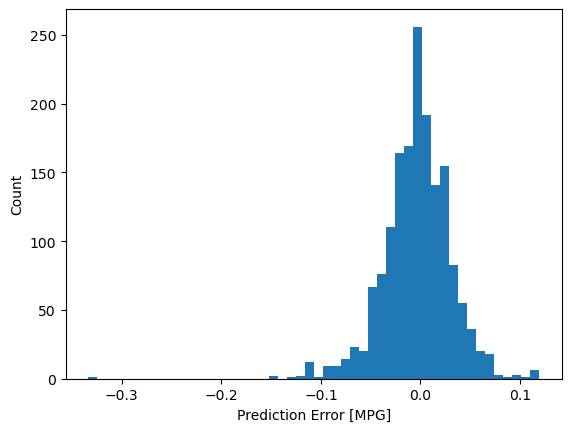

In [32]:
error = val_predictions_denor - val_labels_denor
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

7/7 [==============================] - 0s 25ms/step
(200, 1)


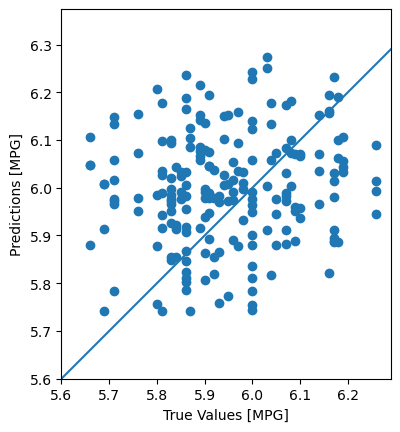

In [41]:
test_predictions = model.predict(X_test_def)
print(test_predictions.shape)
test_predictions_denor = scaler_out.inverse_transform(test_predictions) #valor denormalizado

test_labels_denor = scaler_out.inverse_transform(y_test_def) #valor denormalizado

plt.scatter(test_labels_denor, test_predictions_denor)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([5.6,plt.xlim()[1]])
plt.ylim([5.6,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

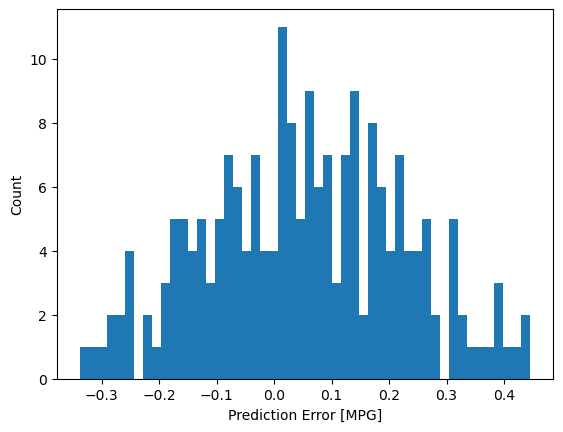

In [42]:
error = test_predictions_denor - test_labels_denor
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")